In [2]:
%env CUDA_VISIBLE_DEVICES=MIG-3b133eb8-ed94-51f8-937f-cbc3e3f3ff2a
%env CUDA_VISIBLE_DEVICES

env: CUDA_VISIBLE_DEVICES=MIG-3b133eb8-ed94-51f8-937f-cbc3e3f3ff2a


'MIG-3b133eb8-ed94-51f8-937f-cbc3e3f3ff2a'

In [3]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import SimpleITK as sitk
import torch

from funcs import sum_along_axis

In [4]:
BASE_FOLDER = Path("eval_results")
model_identifier = "mevis_sam-epoch151-29334c5d6e2b41bf86e613599ffeaff3"
probability = 1.0
best_thresh = -1.0
# new_model_folder = "decoder_only_30p_prompt/2024-08-19 20:08:20/epoch90"
test_res_file = (
    BASE_FOLDER / f"{model_identifier}/Test_inference_results_{probability}_thresh{best_thresh}.json"
)
valid_res_file = (
    BASE_FOLDER / f"{model_identifier}/Validation_inference_results_{probability}_thresh{best_thresh}.json"
)
train_res_file = (
    BASE_FOLDER / f"{model_identifier}/Train_inference_results_{probability}_thresh{best_thresh}.json"
)
# --------------------------------
test_res_file_merged = (
    BASE_FOLDER / f"{model_identifier}/Test_inference_results_{probability}_thresh{best_thresh}_merged.json"
)
valid_res_file_merged = (
    BASE_FOLDER
    / f"{model_identifier}/Validation_inference_results_{probability}_thresh{best_thresh}_merged.json"
)
train_res_file_merged = (
    BASE_FOLDER
    / f"{model_identifier}/Train_inference_results_{probability}_thresh{best_thresh}_merged.json"
)
# --------------------
base_mid_folder = BASE_FOLDER / "base_model_no_prompt" 

base_test_res_file = base_mid_folder / ("Test_inference_results.json")
base_valid_res_file = base_mid_folder / ("Validation_inference_results.json")
base_train_res_file = base_mid_folder / ("Train_inference_results.json")
# -----------------------------
base_test_res_file_merged = base_mid_folder / ("Test_inference_merged_results.json")
base_valid_res_file_merged  = base_mid_folder / ("Validation_inference_merged_results.json")
base_train_res_file_merged  = base_mid_folder / ("Train_inference_merged_results.json")
# --------------------------------------
test_data_file = "data_files/Test_data_files_resampled_v2.json"

In [5]:
def weighted_average(metrics, n_slices):
    total = sum(n_slices)
    weighted_sum = 0
    for m, n in zip(metrics, n_slices):
        weighted_sum += m * n
    return weighted_sum / total


def get_n_slices(path: Path):
    [slice_1, slice_2] = path.stem.split("-")[1:3]
    slice_1 = int(slice_1)
    slice_2 = int(slice_2) if slice_2.isdigit() else int(slice_2.split(".")[0])
    return slice_2 - slice_1 + 1


def merge_metrics(data_dict):
    images = list(data_dict.keys())
    merged_data = {}
    for image in images:
        n_slices = []
        entries = list(data_dict[image].keys())
        entries.remove("prediction_path")
        for p in data_dict[image]["prediction_path"]:
            n_slices.append(get_n_slices(Path(p)))
        merged_data[image] = data_dict[image].copy()
        for entry in entries:
            merged_data[image][entry] = weighted_average(
                merged_data[image][entry], n_slices
            )
        # merged_data[image]["dice_score"] = weighted_average(
        #     merged_data[image]["dice_score"], n_slices
        # )
        # merged_data[image]["iou"] = weighted_average(
        #     merged_data[image]["iou"], n_slices
        # )
        # merged_data[image]["pixel_accuracy"] = weighted_average(
        #     merged_data[image]["pixel_accuracy"], n_slices
        # )
    return merged_data

In [34]:
with open(test_res_file, "r") as f:
    test_dict = json.load(f)
with open(valid_res_file, "r") as f:
    valid_dict = json.load(f)
with open(train_res_file, "r") as f:
    train_dict = json.load(f)

In [35]:
test_dict_merged = merge_metrics(test_dict)
valid_dict_merged = merge_metrics(valid_dict)
train_dict_merged = merge_metrics(train_dict)

with open(test_res_file_merged, "w") as f:
    json.dump(
        test_dict_merged,
        f,
        indent=4,
        sort_keys=False,
        separators=(",", ": "),
    )

with open(valid_res_file_merged, "w") as f:
    json.dump(
        valid_dict_merged,
        f,
        indent=4,
        sort_keys=False,
        separators=(",", ": "),
    )

with open(train_res_file_merged, "w") as f:
    json.dump(
        train_dict_merged,
        f,
        indent=4,
        sort_keys=False,
        separators=(",", ": "),
    )

In [6]:
with open(test_res_file_merged, "r") as f:
    test_dict_merged = json.load(f)
with open(valid_res_file_merged, "r") as f:
    valid_dict_merged = json.load(f)
with open(train_res_file_merged, "r") as f:
    train_dict_merged = json.load(f)

with open(test_data_file, "r") as f:
    test_data_dict = json.load(f)

In [8]:
with open(base_test_res_file_merged, "r") as f:
    base_test_dict_merged = json.load(f)
with open(base_valid_res_file_merged, "r") as f:
    base_valid_dict_merged = json.load(f)
with open(base_train_res_file_merged, "r") as f:
    base_train_dict_merged = json.load(f)

In [19]:
def get_2d_sample(sample_dict):
    mask_parts = [Path(x) for x in sample_dict["prediction_path"]]
    mask_merged = np.concatenate(
        [sitk.GetArrayFromImage(sitk.ReadImage(x)) for x in mask_parts], axis=0
    )
    # smallest_dimension_index = np.argmin(img_direct.shape)
    # img_direct = torch.from_numpy(img_direct)
    mask_merged = torch.from_numpy(mask_merged)
    summed = sum_along_axis(mask_merged, axis=0)
    return mask_parts[0].name, summed

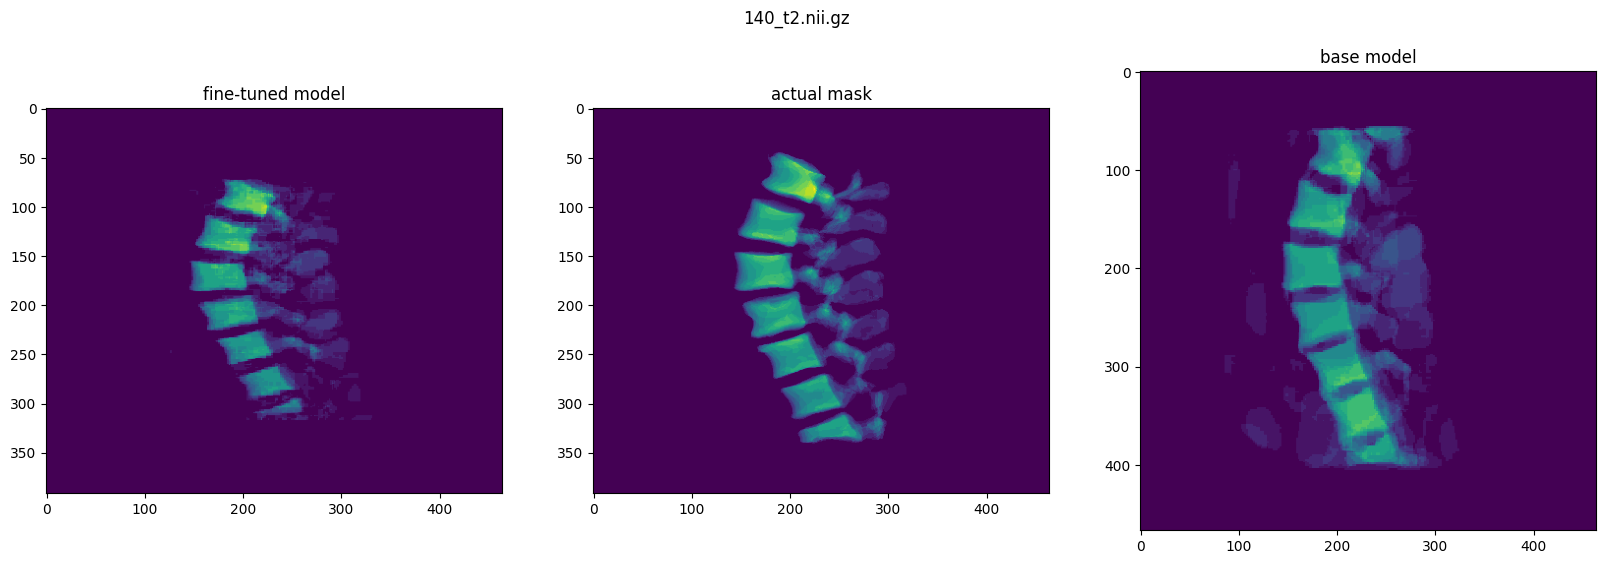

In [21]:
sample_name = list(test_dict_merged.keys())[25]
_, sample_summed = get_2d_sample(test_dict_merged[sample_name])
_, base_sample_summed = get_2d_sample(base_test_dict_merged[sample_name])
actual_mask = sitk.GetArrayFromImage(
    sitk.ReadImage(test_data_dict[sample_name]["mask_path"])
)
actual_mask = sum_along_axis(torch.from_numpy(actual_mask), 0)
vmin = min(
    torch.min(base_sample_summed), torch.min(sample_summed), torch.min(actual_mask)
)
vmax = max(
    torch.max(base_sample_summed), torch.max(sample_summed), torch.max(actual_mask)
)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].imshow(sample_summed, vmin=vmin, vmax=vmax)
ax[0].set_title("fine-tuned model")
ax[1].imshow(actual_mask, vmin=vmin, vmax=vmax)
ax[1].set_title("actual mask")
ax[2].imshow(base_sample_summed, vmin=vmin, vmax=vmax)
ax[2].set_title("base model")
fig.suptitle(sample_name)
plt.show()

In [9]:
file_names = [
    "Test_inference_merged_results",
    "Validation_inference_merged_results",
    "Train_inference_merged_results",
    "Test_inference_results_0.0_thresh-1.0_merged",
    "Validation_inference_results_0.0_thresh-1.0_merged",
    "Train_inference_results_0.0_thresh-1.0_merged",
    "Test_inference_results_1.0_thresh-1.0_merged",
    "Validation_inference_results_1.0_thresh-1.0_merged",
    "Train_inference_results_1.0_thresh-1.0_merged",
]
mid_folders = [
    "2024-08-15 12:15:20_epoch90_no_prompt_best_thresh",
    "2024-08-15 12:15:20_epoch90_with_prompt_best_thresh",
    "base_model_no_prompt",
    "base_model_with_prompt",
    "mevis_sam-epoch151-29334c5d6e2b41bf86e613599ffeaff3",
]
base_folders = [
    "eval_results",
]
res_files = {}
for base in base_folders:
    for mid in mid_folders:
        # version
        if "base" in mid:
            pre = "base"
        elif "mevis_sam" in mid:
            pre = "v2"
        else:
            pre= "v1"
        for fname in file_names:
            # prompts
            if ("_0.0_" in fname) or ("no_prompt" in mid):
                post = "np"
            else:
                post = "prompted"
            # data group    
            if "Test" in fname:
                typ = "test"
            elif "Validation" in fname:
                typ = "valid"
            elif "Train" in fname:
                typ = "train"
                
            file = Path(base) / f"{mid}/{fname}.json"
            if file.exists():
                df = pd.read_json(file).T
                for ind in df.index:
                    df.loc[ind, "n_slices"] = get_n_slices(
                        Path(df.loc[ind, "prediction_path"][0])
                    )
                res_files[f"{pre}_{typ}_{post}"] = df.drop("prediction_path", axis=1).copy(
                    True
                )
            else:
                continue

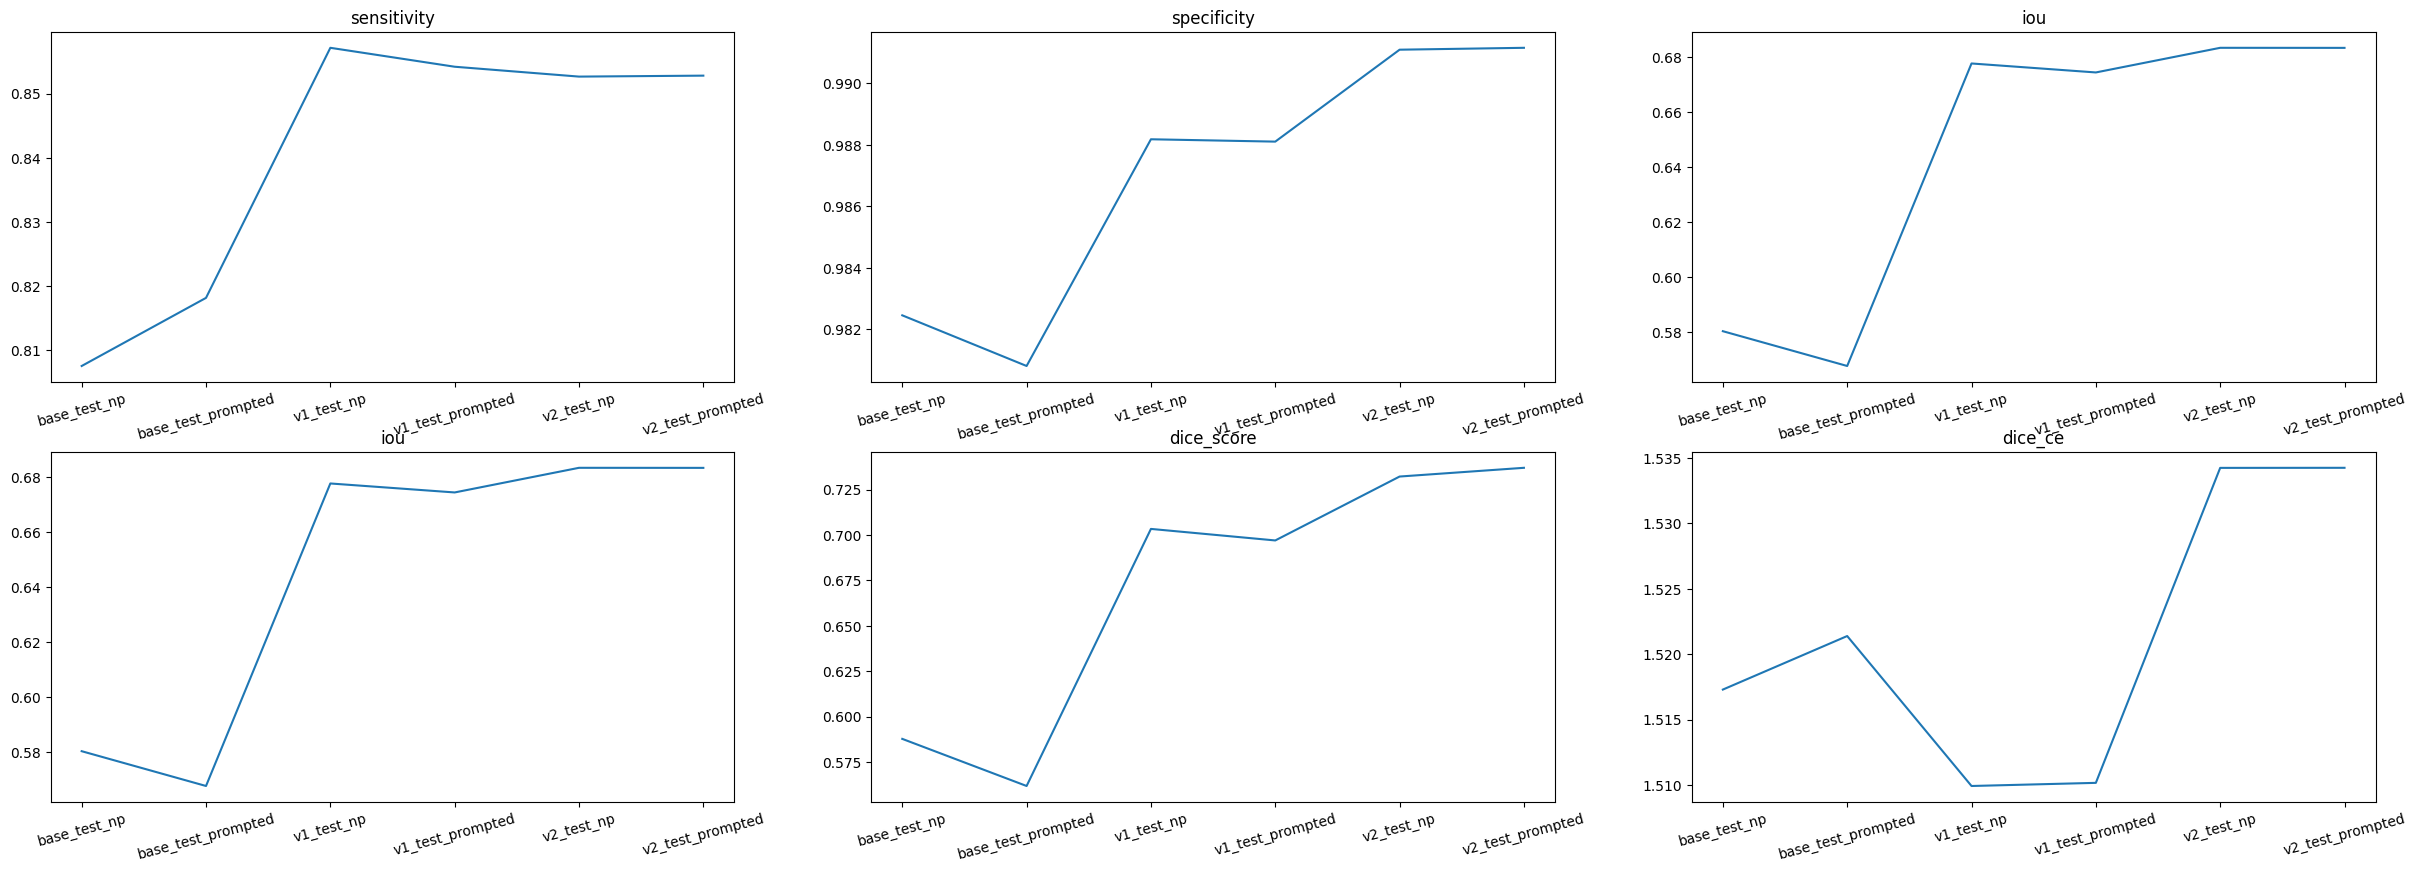

In [10]:
selected = sorted([x for x in res_files.keys() if "test" in x])
metrics = list(res_files[selected[0]].columns)
fig, ax = plt.subplots(2, len(metrics) // 2 + len(metrics) % 2, figsize=(30, 10))

for i in range(len(ax)):
    for j in range(len(ax[i])):
        ax[i, j].plot(
            selected, [res_files[x].mean(axis=0)[metrics[2 * i + j]] for x in selected]
        )
        ax[i, j].set_title(metrics[2 * i + j])
        plt.setp(ax[i, j].get_xticklabels(), rotation=15)

In [12]:
test_conditions = [condition for condition in res_files.keys() if "test" in condition]

# Separate base model and new model
base_conditions = sorted([condition for condition in test_conditions if "base" in condition])
v2_conditions = sorted([condition for condition in test_conditions if "v2" in condition])
v1_conditions = sorted([condition for condition in test_conditions if ("v1" in condition)])

# Separate prompted and unprompted results
prompted_conditions = sorted([
    condition
    for condition in test_conditions
    if "prompt" in condition
])
unprompted_conditions = sorted([
    condition
    for condition in test_conditions
    if "np" in condition
])


metrics = list(res_files[test_conditions[0]].columns)
metrics.remove("n_slices")

In [14]:
v1_conditions

['v1_test_np', 'v1_test_prompted']

sensitivity [0.8181062253099629, 0.8541783896520817, 0.8527889150891904]
specificity [0.9808052030185368, 0.988098724565557, 0.9911484330991912]
iou [0.5676301901413946, 0.6742559419737921, 0.6831833488977516]
dice_score [0.5617253853827298, 0.6969693064689635, 0.7369782160042532]
dice_ce [1.5213765840904385, 1.510161405139499, 1.5342271649425556]


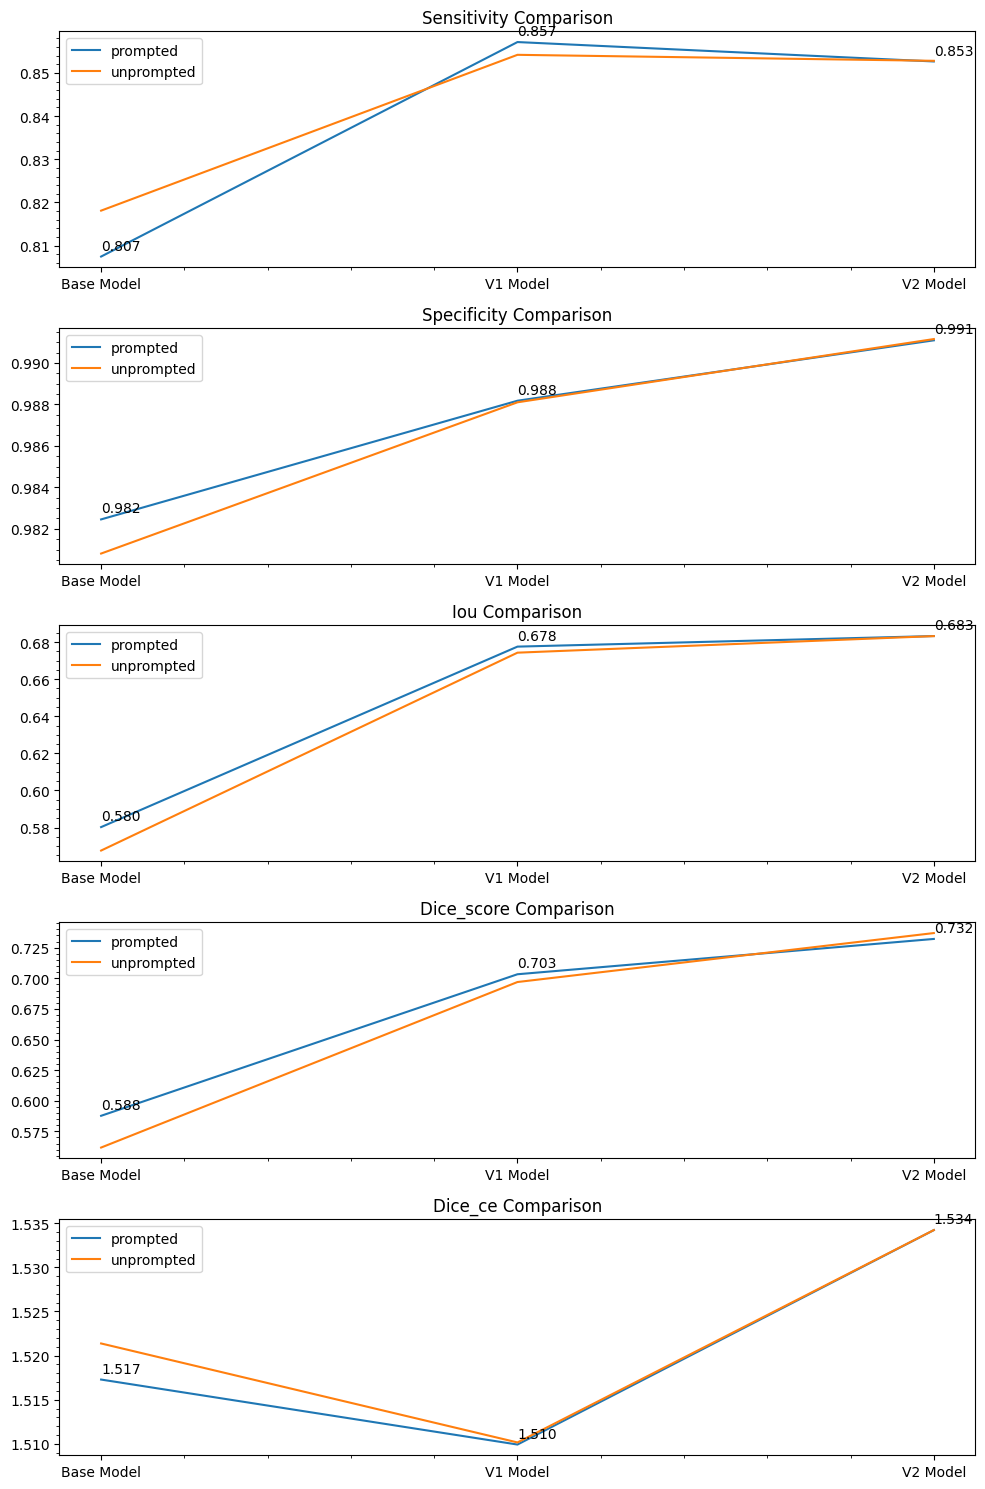

In [13]:
#TODO:this
metrics = list(res_files[test_conditions[0]].columns)
metrics.remove("n_slices")
fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 15))

for i, metric in enumerate(metrics):
    x_labels = [
        "Base Model",
        "V1 Model",
        "V2 Model",
    ]
    prompted_vals = [res_files[condition].mean(axis=0)[metric] for condition in unprompted_conditions]
    unprompted_vals = [res_files[condition].mean(axis=0)[metric] for condition in prompted_conditions]
    axes[i].plot(x_labels, prompted_vals, label="prompted")
    axes[i].plot(x_labels, unprompted_vals, label="unprompted")
    # axes[i].xaxis.set_major_locator(ticker.MultipleLocator(6))
    axes[i].minorticks_on()
    for m, n in zip(x_labels, prompted_vals):
        axes[i].annotate(
            f"{n:.3f}", xy=(m, n), xytext=(0, 5), textcoords="offset points"
        )
    axes[i].set_title(f"{metric.capitalize()} Comparison")
    axes[i].legend()
    print(metric, unprompted_vals)

plt.tight_layout()
plt.show()

/tmp/ipykernel_258676/1445560241.py:4: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_v1 = df_v1.applymap(lambda x: float(x))
/tmp/ipykernel_258676/1445560241.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_base = df_base.applymap(lambda x: float(x))
/tmp/ipykernel_258676/1445560241.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_v2 = df_v2.applymap(lambda x: float(x))
/tmp/ipykernel_258676/1445560241.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


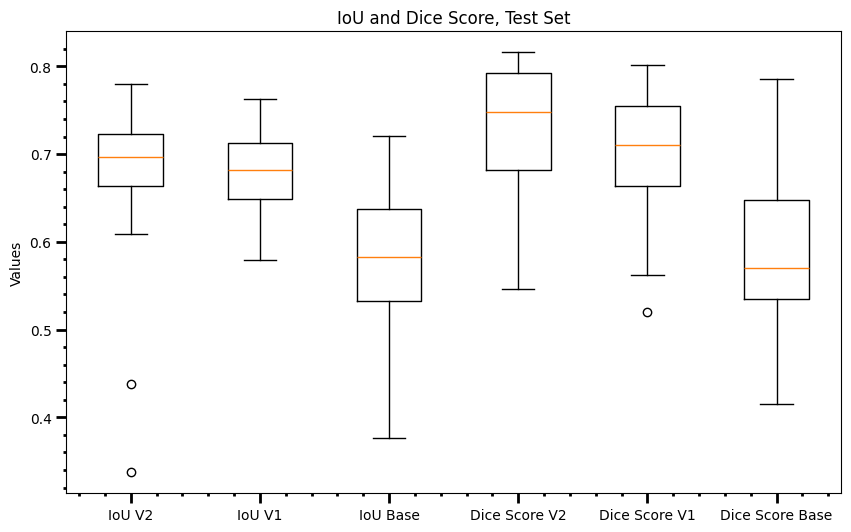

In [17]:
df_v1 = pd.DataFrame.from_dict(res_files["v1_test_np"])
df_base = pd.DataFrame.from_dict(res_files["base_test_np"])
df_v2 = pd.DataFrame.from_dict(res_files["v2_test_np"])
df_v1 = df_v1.applymap(lambda x: float(x))
df_base = df_base.applymap(lambda x: float(x))
df_v2 = df_v2.applymap(lambda x: float(x))
fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(
    [df_v2["iou"], df_v1["iou"], df_base["iou"], df_v2["dice_score"], df_v1["dice_score"], df_base["dice_score"]],
    labels=[
        "IoU V2",
        "IoU V1",
        "IoU Base",
        "Dice Score V2",
        "Dice Score V1",
        "Dice Score Base",
    ],
)
ax.set_title("IoU and Dice Score, Test Set")
ax.set_ylabel("Values")
# ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_minor_locator(ticker.AutoLocator())  # Adjust the interval as needed
ax.tick_params(which="both", width=2)
ax.tick_params(which="major", length=7)
ax.minorticks_on()
plt.show()

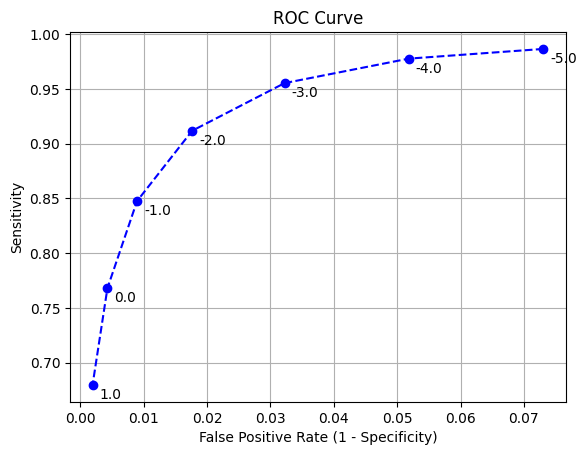

In [11]:
# roc
BASE_FOLDER = Path("eval_results")
model_identifier = "mevis_sam-epoch151-29334c5d6e2b41bf86e613599ffeaff3"
probability = 0.0
test_res_file_roc = (
    BASE_FOLDER
    / f"{model_identifier}/roc/Test_inference_results_roc_{probability}.json"
)
valid_res_file_roc = (
    BASE_FOLDER
    / f"{model_identifier}/roc/Validation_inference_results_roc_{probability}.json"
)
train_res_file_roc = (
    BASE_FOLDER
    / f"{model_identifier}/roc/Train_inference_results_roc_{probability}.json"
)

with open(test_res_file_roc, "r") as f:
    test_data_dict_roc = json.load(f)
with open(valid_res_file_roc, "r") as f:
    valid_data_dict_roc = json.load(f)
with open(train_res_file_roc, "r") as f:
    train_data_dict_roc = json.load(f)

thresh_vals = [round(float(x), 4) for x in test_data_dict_roc.keys()]
test_res_dfs = {}
for i, thresh in enumerate(test_data_dict_roc.keys()):
    test_res_dfs[str(thresh_vals[i])] = pd.DataFrame.from_dict(
        merge_metrics(test_data_dict_roc[thresh])
    ).T.drop("prediction_path", axis=1)


# Lists to store sensitivities, specificities, and thresholds
sensitivities = []
specificities = []
ious = []
dice_scores = []

# Populate the lists with the mean sensitivity and specificity for each threshold
for threshold, df in test_res_dfs.items():
    sensitivities.append(df.mean()["sensitivity"])
    specificities.append(df.mean()["specificity"])
    ious.append(df.mean()["iou"])
    dice_scores.append(df.mean()["dice_score"])

# Convert specificities to false positive rates (1 - specificity)
false_positive_rates = [1 - spec for spec in specificities]


# Plotting the ROC curve
plt.figure()
plt.plot(false_positive_rates, sensitivities, marker="o", linestyle="--", color="b")
for i, threshold in enumerate(thresh_vals):
    plt.annotate(
        threshold,
        (false_positive_rates[i], sensitivities[i]),
        textcoords="offset points",
        xytext=(5, -10),
    )

plt.title("ROC Curve")
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("Sensitivity")
plt.grid()
plt.show()

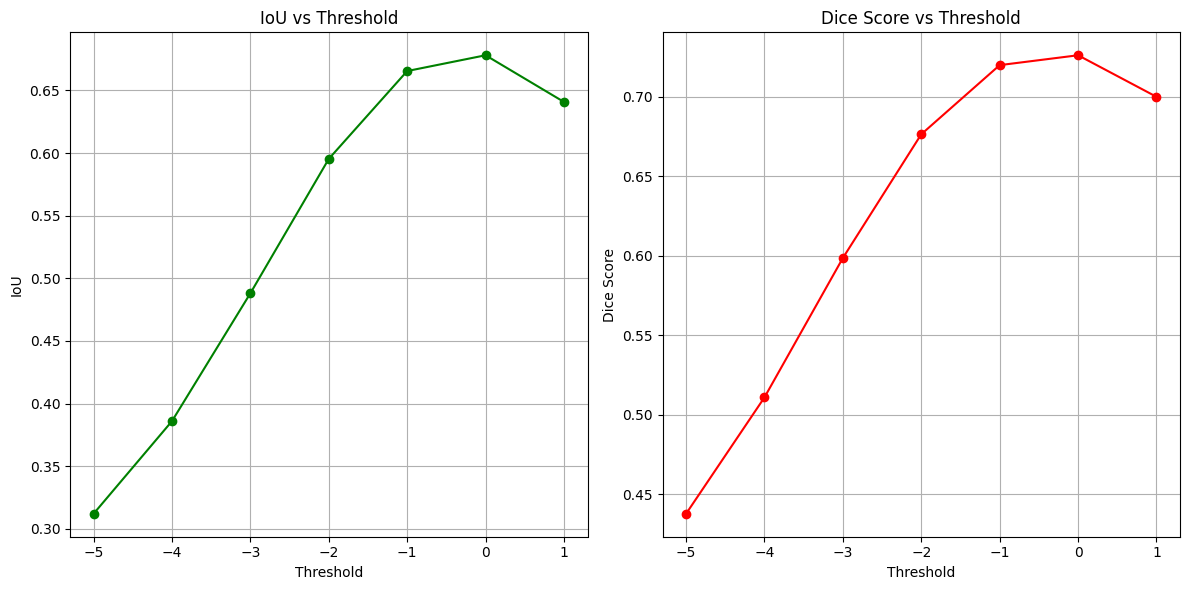

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot IoU
ax1.plot(thresh_vals, ious, marker="o", linestyle="-", color="g")
ax1.set_title("IoU vs Threshold")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("IoU")
ax1.grid()

# Plot Dice score
ax2.plot(thresh_vals, dice_scores, marker="o", linestyle="-", color="r")
ax2.set_title("Dice Score vs Threshold")
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Dice Score")
ax2.grid()

plt.tight_layout()
plt.show()